### Now let's try to learn a better prior describing latent variables of the dataset.

#### First we'll use an autoencoder to produce a latent version (10 dimensional elements) of the dataset

#### then we train a mixture of gaussian on the latent dataset by maximising the log-likelihood, The resulting mixture will be used as prior in the next VAE

In [1]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential, Model
import tf_keras as tfk
import tensorflow_probability as tfp
import random
import numpy as np
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

import tf_keras as tfk
tfkl = tfk.layers

from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = "c:\\users\\talibit\\Drug_discovery_data\\alzheimersdata.txt"
data = open(DATA_PATH, 'r').read().splitlines()
new = []
count =0
for molecule in data:
    count+=1
    if 30 < len(molecule) < 50 and count < 300000:
        if ('T' not in molecule) and ('V' not in molecule) and ('g' not in molecule) and ('L' not in molecule) and ('8' not in molecule):
            new.append(molecule)

max_seq_len = len(max(new, key=len)) 

l = [['$']+ list(i) for i in new]
#l = [['$']+ [i] for i in new]
data = pad_sequences(l, maxlen=max_seq_len+1, padding="post", value="£",dtype=object) 

In [3]:
tokenizer = Tokenizer(num_words=None, char_level=True, lower=False) 

tokenizer.fit_on_texts(data) 
new_data = tokenizer.texts_to_sequences(data) 
new_data = np.array(new_data)
new_data = np.expand_dims(new_data,-1)

In [4]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)

In [5]:
seed = 1
np.random.seed(seed)
full_train, x_test = train_test_split(np.array(new_data), test_size=0.2, random_state=seed)

x_train, x_val = train_test_split(np.array(full_train), test_size=0.1, random_state=seed)

In [6]:
## building and training the autoencoder to create the latent version of our database


encoder = tfk.Sequential([
    tfkl.Flatten(input_shape = (50,1)),
    tfkl.Dense(40, activation = 'sigmoid'),
    tfkl.Dense(20, activation = 'sigmoid'),
    tfkl.Dense(10, activation = 'sigmoid')
])

decoder = tfk.Sequential([
    tfkl.Dense(20, activation = 'sigmoid', input_shape = (10,)),
    tfkl.Dense(40, activation = 'sigmoid'),
    tfkl.Dense(50, activation = 'sigmoid'),
    tfkl.Reshape((50,1))
])

autoencoder = tfk.Model(inputs = encoder.input, outputs = decoder(encoder.output))
X_train = np.concatenate((x_train, x_val, x_test), axis=0)
autoencoder.compile(loss = 'mse', optimizer = 'sgd')
history = autoencoder.fit(X_train,X_train, epochs = 100)



Epoch 1/100

27/27 [==============================] - 1s 1ms/step - loss: 54.3658
Epoch 2/100
27/27 [==============================] - 0s 846us/step - loss: 53.9766
Epoch 3/100
27/27 [==============================] - 0s 885us/step - loss: 53.6043
Epoch 4/100
27/27 [==============================] - 0s 1ms/step - loss: 53.2515
Epoch 5/100
27/27 [==============================] - 0s 909us/step - loss: 52.9204
Epoch 6/100
27/27 [==============================] - 0s 923us/step - loss: 52.6120
Epoch 7/100
27/27 [==============================] - 0s 1000us/step - loss: 52.3276
Epoch 8/100
27/27 [==============================] - 0s 885us/step - loss: 52.0669
Epoch 9/100
27/27 [==============================] - 0s 1ms/step - loss: 51.8302
Epoch 10/100
27/27 [==============================] - 0s 923us/step - loss: 51.6167
Epoch 11/100
27/27 [==============================] - 0s 962us/step - loss: 51.4253
Epoch 12/100
27/27 [==============================] - 0s 1ms/step - loss: 51.2540
Epoch

### Visualization of data before and after compression

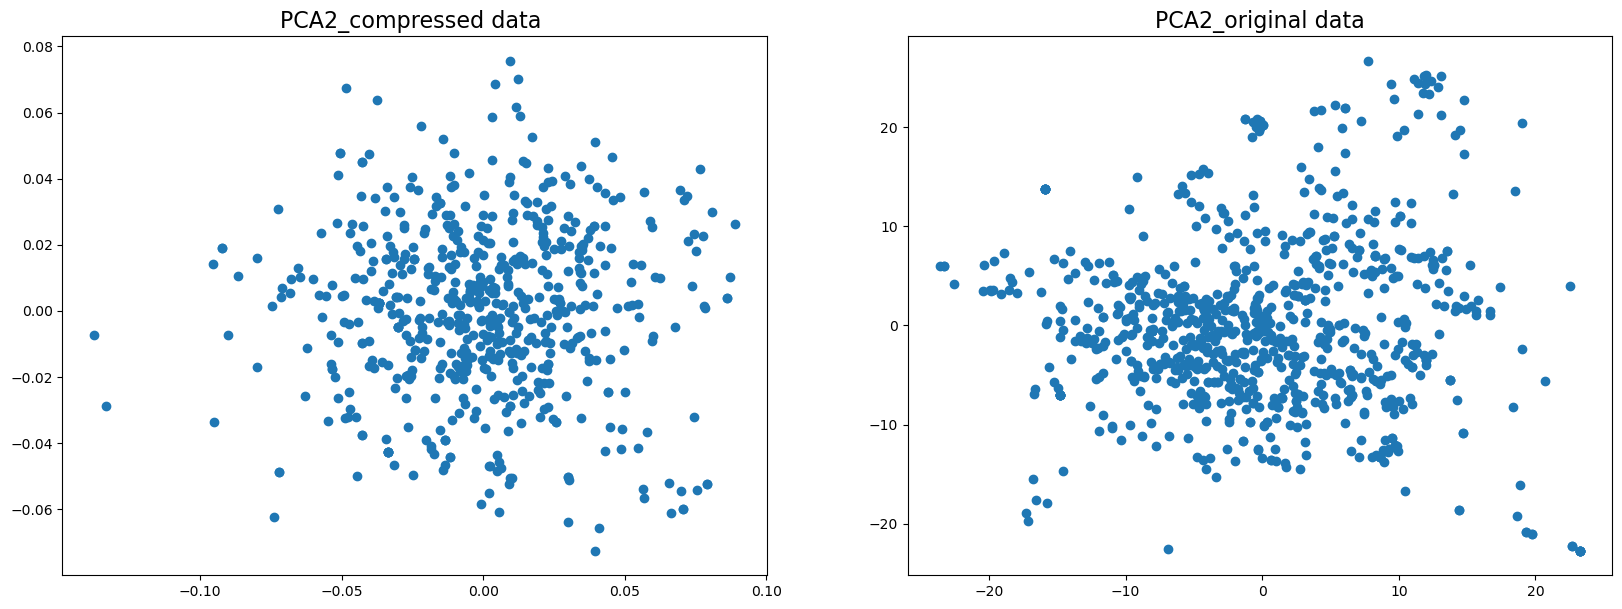

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)

X_train = np.squeeze(X_train)

latent_data1 =  pca.fit_transform(encoder(x_train))
orig_data =  pca.fit_transform(X_train)

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1) 
plt.scatter(x = latent_data1[:, 0], 
            y = latent_data1[:, 1])
plt.title("PCA2_compressed data ", fontsize=16)

plt.subplot(1, 2, 2) 
plt.scatter(x = orig_data[:, 0], 
            y = orig_data[:, 1])
plt.title("PCA2_original data", fontsize=16)
plt.show();



### The overall shape of data remain almost invariant

### Now in our third model we will use a trainable distribution on the latent version of our dataset
### then we'll use the trained prior to compute KL divergence loss of the encoder.
### I choosed  the prior to be a trainable  mixture of gaussian with 2 modes, I'll also modify the output distribution of the encoder to be also a mixture of gaussian with 2 modes

In [9]:
### let's create a trainable mixture of guassian

num_modes = 2
latent_dim = 10

logits = tf.Variable(tf.zeros([num_modes]), name='logits')
mixture_distribution = tfd.Categorical(logits=logits)
loc = tf.Variable(tf.random.normal([num_modes,latent_dim]), name = 'loc')
scale_diag = tfp.util.TransformedVariable(tf.Variable(tf.ones([num_modes,latent_dim])),bijector = tfb.Softplus(), name = 'scale')
components_distribution=tfd.MultivariateNormalDiag(loc = loc, scale_diag = scale_diag)

prior = tfd.MixtureSameFamily(
                               mixture_distribution = mixture_distribution,
                               components_distribution = components_distribution
                             )

In [10]:
trainable_params = prior.trainable_variables
for param in trainable_params:
    print(f'Parameter name: {param.name}, shape: {param.shape}')

print(f'Total number of trainable parameters: {sum(tf.size(param).numpy() for param in trainable_params)}')

Parameter name: loc:0, shape: (2, 10)
Parameter name: scale:0, shape: (2, 10)
Parameter name: logits:0, shape: (2,)
Total number of trainable parameters: 42


In [11]:
prior.trainable_variables

(<tf.Variable 'loc:0' shape=(2, 10) dtype=float32, numpy=
 array([[-1.5475836 ,  0.04013257,  0.9821207 , -0.649504  , -1.239549  ,
          0.4102057 ,  1.0949222 ,  1.4478067 ,  2.233892  ,  0.17854123],
        [ 0.8289684 , -0.43684345, -1.3071818 , -0.77001053, -0.6412498 ,
         -0.08371095, -2.8399231 , -2.0882392 , -0.8759953 , -0.44539964]],
       dtype=float32)>,
 <tf.Variable 'scale:0' shape=(2, 10) dtype=float32, numpy=
 array([[0.54132485, 0.54132485, 0.54132485, 0.54132485, 0.54132485,
         0.54132485, 0.54132485, 0.54132485, 0.54132485, 0.54132485],
        [0.54132485, 0.54132485, 0.54132485, 0.54132485, 0.54132485,
         0.54132485, 0.54132485, 0.54132485, 0.54132485, 0.54132485]],
       dtype=float32)>,
 <tf.Variable 'logits:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>)

In [12]:
# training the new prior with the latent dataset
latent_data = encoder(x_train)
num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []

for epoch in range(num_epochs):
    #print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    for train in latent_data:
        with tf.GradientTape() as tape:
            tape.watch(prior.trainable_variables)
            loss = -prior.log_prob(train)
        train_loss(loss)
        grads = tape.gradient(loss, prior.trainable_variables)
        opt.apply_gradients(zip(grads, prior.trainable_variables))

    print(f"Epoch : {epoch}.....Loss : {train_loss.result().numpy()}")
    train_losses.append(train_loss.result().numpy())

Epoch : 0.....Loss : 11.835898399353027
Epoch : 1.....Loss : 2.2011055946350098
Epoch : 2.....Loss : -4.75408411026001
Epoch : 3.....Loss : -11.11767292022705
Epoch : 4.....Loss : -16.741025924682617
Epoch : 5.....Loss : -20.719308853149414
Epoch : 6.....Loss : -22.882991790771484
Epoch : 7.....Loss : -24.040813446044922
Epoch : 8.....Loss : -24.73563575744629
Epoch : 9.....Loss : -25.162988662719727


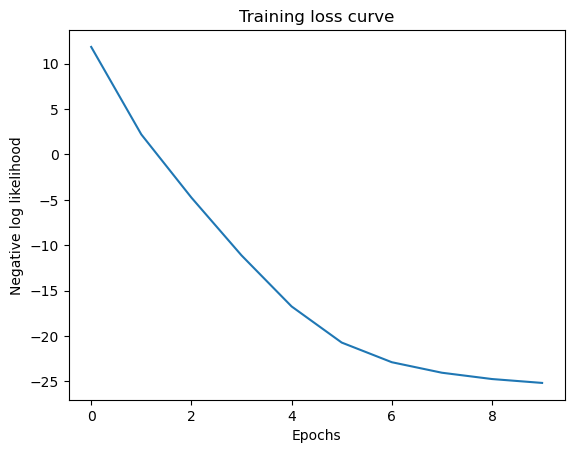

In [13]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training loss curve")
plt.show()

#### No need to further epochs as the curve stagnated...

In [14]:
# the prior parameters have been trained

prior.trainable_variables

(<tf.Variable 'loc:0' shape=(2, 10) dtype=float32, numpy=
 array([[-1.2072648 ,  0.37815487,  0.64399534, -0.30577552, -0.90009546,
          0.52572435,  0.78427434,  1.0620664 ,  1.894396  ,  0.5049423 ],
        [ 0.54280245,  0.52037096,  0.4990164 ,  0.7131577 ,  0.57104194,
          0.52363783,  0.7102157 ,  0.62600034,  0.62220645,  0.6187522 ]],
       dtype=float32)>,
 <tf.Variable 'scale:0' shape=(2, 10) dtype=float32, numpy=
 array([[ 0.83444303,  0.12512586,  0.12508745,  0.6842182 ,  0.81413823,
          0.14483042,  0.13154161,  0.08470502,  0.7867761 ,  0.12770045],
        [-3.9066203 , -3.9207175 , -4.23991   , -3.853     , -3.8757334 ,
         -3.6849084 , -3.908388  , -4.021346  , -3.7212605 , -3.9557106 ]],
       dtype=float32)>,
 <tf.Variable 'logits:0' shape=(2,) dtype=float32, numpy=array([-2.2603986,  2.2603986], dtype=float32)>)

In [15]:
kl_regularizer2= tfpl.KLDivergenceRegularizer(prior,
                                              use_exact_kl = False, 
                                              weight = 0.01,
                                              test_points_fn = lambda q :q.sample(3),
                                              test_points_reduce_axis = None) 

In [38]:

encoder2 = tfk.Sequential([
        tfkl.LSTM(128, input_shape=(50,1), return_sequences=True),
        tfkl.Dropout(0.15),
        tfkl.MaxPooling1D(pool_size=2),
        tfkl.LSTM(256, return_sequences=True),
        tfkl.Dropout(0.05),
        tfkl.MaxPooling1D(pool_size=2),
        tfkl.LSTM(512, return_sequences=True),
        tfkl.Dropout(0.25),
        tfkl.Flatten(),
        tfkl.Dense(tfpl.MixtureSameFamily.params_size(
            num_components=num_modes,
            component_params_size=tfpl.MultivariateNormalTriL.params_size(latent_dim)
        )),
        tfpl.MixtureSameFamily(
            num_components=num_modes,
            component_layer=tfpl.MultivariateNormalTriL(latent_dim),
            activity_regularizer = kl_regularizer2)
        
    ])
encoder2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50, 128)           66560     
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 25, 128)           0         
 g1D)                                                            
                                                                 
 lstm_13 (LSTM)              (None, 25, 256)           394240    
                                                                 
 dropout_13 (Dropout)        (None, 25, 256)           0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 12, 256)           0         
 g1D)                                                 

In [39]:
# listing the trainable parameters of the mixture of gaussian of the encoder

for e in encoder2.layers[-1].trainable_variables:
    print(e.name  ,e.shape)

loc:0 (2, 10)
scale:0 (2, 10)
logits:0 (2,)


In [40]:
decoder2 = tfk.Sequential([
    tfkl.Dense(10, activation = 'relu', input_shape =(latent_dim,)),
    tfkl.Reshape((latent_dim,1)),
    tfkl.LSTM(512, return_sequences=True),
    tfkl.Dropout(0.05),
    tfkl.UpSampling1D(size = 2),
    tfkl.LSTM(256, return_sequences=True),
    tfkl.Dropout(0.05),
    tfkl.UpSampling1D(size = 2),
    tfkl.LSTM(128, return_sequences=True),
    tfkl.Dropout(0.05),
    tfkl.Flatten(),
    tfkl.Dense(50 * (vocab_size+1)),  # Output 50 * 37 logits
    tfkl.Reshape((50, vocab_size+1)),  # Reshape to (50, 37)
    tfpl.DistributionLambda(lambda t: tfd.Independent(
        tfd.Categorical(logits=t), reinterpreted_batch_ndims=1))

])
decoder2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 reshape_5 (Reshape)         (None, 10, 1)             0         
                                                                 
 lstm_15 (LSTM)              (None, 10, 512)           1052672   
                                                                 
 dropout_15 (Dropout)        (None, 10, 512)           0         
                                                                 
 up_sampling1d_4 (UpSamplin  (None, 20, 512)           0         
 g1D)                                                            
                                                                 
 lstm_16 (LSTM)              (None, 20, 256)           787456    
                                                      

In [41]:
vae2 = tfk.Model(inputs=encoder2.inputs, outputs=decoder2(encoder2.outputs))

In [42]:
optimizer = tfk.optimizers.Adam(learning_rate=0.0005)
vae2.compile(optimizer=optimizer, loss=lambda x, pred : -tf.reduce_mean(pred.log_prob(x)))

In [43]:
vae2.fit(x = x_train, y = np.squeeze(x_train),validation_data = (x_val, np.squeeze(x_val)), epochs = 30)

Epoch 1/30
20/20 [==============================] - 18s 450ms/step - loss: 131.2957 - val_loss: 110.2793
Epoch 2/30
20/20 [==============================] - 6s 307ms/step - loss: 107.6524 - val_loss: 107.1843
Epoch 3/30
20/20 [==============================] - 6s 316ms/step - loss: 106.0837 - val_loss: 106.7136
Epoch 4/30
20/20 [==============================] - 6s 311ms/step - loss: 105.2122 - val_loss: 106.4386
Epoch 5/30
20/20 [==============================] - 6s 304ms/step - loss: 104.9731 - val_loss: 106.6327
Epoch 6/30
20/20 [==============================] - 6s 281ms/step - loss: 105.1191 - val_loss: 106.7232
Epoch 7/30
20/20 [==============================] - 6s 290ms/step - loss: 104.9120 - val_loss: 106.6860
Epoch 8/30
20/20 [==============================] - 5s 269ms/step - loss: 104.7263 - val_loss: 106.6561
Epoch 9/30
20/20 [==============================] - 5s 257ms/step - loss: 104.7604 - val_loss: 106.2214
Epoch 10/30
20/20 [==============================] - 5s 270ms/s

In [44]:
# Evaluate the model on the test set
test_loss = vae2.evaluate(x_test)
print("Test loss: {}".format(test_loss))

6/6 [==============================] - 3s 21ms/step - loss: 0.0730
Test loss: 0.07298082858324051


In [45]:
#Reconstruction of example

print(data.shape)

random_number = random.randint(0, 846)
print("the initial smile string is:",''.join(data[random_number,:].tolist()))

new_data = tokenizer.texts_to_sequences(data[random_number,:]) 
new_data = np.expand_dims(new_data,0)
new_data.shape
q = encoder2(new_data)
q
p = decoder2(q.mean())


sequence = p.sample().numpy()
tokenizer.sequences_to_texts(sequence)

(847, 50)
the initial smile string is: $O=C1NC(=O)C(c2cn(CCCO)c3ncccc23)=C1c1cccs1£££££££


['$ O [ . @ @ n ( c N - c c = N 3 c ( ( - ) c c - c c c n c c c n c c n 3 c 1 £ ) 4 c £ 1 £ £ n £ £ £']

In [49]:
# Generation
n_samples = 7000
samples = prior.sample(n_samples)
output_distribution = decoder2(samples)
smiles = tokenizer.sequences_to_texts(output_distribution.sample().numpy())
smiles

['$ N = 1 c N c ( - 2 2 ( ( n 3 N C ( C - 3 ) ) [ c c c = c c c 2 c ( £ c c ) £ C c C £ ) £ 1 £ £ £ 1',
 '$ C = ( C c c - c c - c c n c 2 C \\ n ) [ c C c c O C 3 1 - 2 c 2 c B 3 c N c c £ C c C £ £ C c £ £',
 '$ C C 1 c c c = = n C H 1 o c ( n c c c c 5 ( 2 c ( ) c N c ( c O - C c c 3 c C ) £ O £ £ 2 c £ £ £',
 '$ C C c ( C n C = c ( c - c n N c C 1 [ c ) ( c 3 c C 1 ) O c ( c - c 3 ) C c 4 C c ) £ O l C £ = £',
 '$ C O 1 ( N c - ( N [ ( 2 c c c n ( c - O ) c c c c O c c O ) 1 c ( 2 c ) C O ( O £ £ c c £ £ n £ £',
 '$ N = S @ ) c c N c - n 2 ] ( c 2 ( c c - c ( = c C n o O ) N 4 c ( C 2 c C 1 C 2 c 1 £ c £ £ £ 2 £',
 '$ O c $ 1 N H c ( / 2 c c c C C ( c c C C c c - n c ( F ) c 1 c ( 2 c ) 4 £ c c £ ( 1 £ £ £ ) £ £ £',
 '$ C r c 1 ( c c - ( c c ) ( 1 3 C [ ( c c ( c C ( c 4 3 C ( ) O c c c ) 3 1 c 2 £ £ O n £ £ £ £ £ 1',
 '$ O = 1 c c c C ( 1 c C c c [ ( n ( ( ] ( c ( c 2 c ) c C N ) 1 c ) O ) c ) c 2 £ £ 2 ) £ £ £ c £ £',
 '$ C n C 1 c c c ] c ) n c N 2 2 c N c = c N 1 c c c n 2 ( r o

In [50]:
from rdkit import Chem
def checkSMILES(smiles):
	valid_smiles = []
	for smile in smiles:
		new = ''
		for char in smile:
			if char != '$' and char != '£':	
				new += char

		if Chem.MolFromSmiles(new, sanitize=False) is not None and len(new) > 15:
			valid_smiles.append(new)
			print(new)

	return valid_smiles
    
checkSMILES(smiles)

B O c C c ( C / n / c n n c C 2 c c 2 - ) c ) c ) c c ( ) c c C ) o = 1 ) c O   [  )      


[11:06:10] SMILES Parse Error: syntax error while parsing: N = 1 c N c ( - 2 2 ( ( n 3 N C ( C - 3 ) ) [ c c c = c c c 2 c (  c c )  C c C  )  1    1
[11:06:10] SMILES Parse Error: Failed parsing SMILES ' N = 1 c N c ( - 2 2 ( ( n 3 N C ( C - 3 ) ) [ c c c = c c c 2 c (  c c )  C c C  )  1    1' for input: ' N = 1 c N c ( - 2 2 ( ( n 3 N C ( C - 3 ) ) [ c c c = c c c 2 c (  c c )  C c C  )  1    1'
[11:06:10] SMILES Parse Error: syntax error while parsing: C = ( C c c - c c - c c n c 2 C \ n ) [ c C c c O C 3 1 - 2 c 2 c B 3 c N c c  C c C   C c  
[11:06:10] SMILES Parse Error: Failed parsing SMILES ' C = ( C c c - c c - c c n c 2 C \ n ) [ c C c c O C 3 1 - 2 c 2 c B 3 c N c c  C c C   C c  ' for input: ' C = ( C c c - c c - c c n c 2 C \ n ) [ c C c c O C 3 1 - 2 c 2 c B 3 c N c c  C c C   C c  '
[11:06:10] SMILES Parse Error: syntax error while parsing: C C 1 c c c = = n C H 1 o c ( n c c c c 5 ( 2 c ( ) c N c ( c O - C c c 3 c C )  O   2 c   
[11:06:10] SMILES Parse Error: Failed p

['B O c C c ( C / n / c n n c C 2 c c 2 - ) c ) c ) c c ( ) c c C ) o = 1 ) c O   [  )      ']

##### No better result even if the prior is supposed to describe better the latent space.

##### The decoder does not generate more molecules because the learned latent space is too close to the supposed real latent space which is learned from a small dataset with a small variability ( only 37 possible characters in each position of the sequence)